# CMA-ES_MGDA algorithm

## Overview

In the training process of PINNS network, highly nonlinear and non-convex optimization problems often occur. This algorithm is a combination of gradient-free optimization algorithm CMA-ES and multi-objective gradient optimization algorithm (mgda) to overcome the problems of highly non-convex and gradient anomalies in optimization.

## Technical path

The specific process of MindFlow to solve this problem is as follows:

1. Create a data set
2. Build neural network model and optimizer
3. Build cma-es algorithm
4. Model training

## Import code pack

In [ ]:
import random
import time
import os
import argparse

import cma
import numpy as np

from mindspore import context, nn, set_seed, save_checkpoint, data_sink
from mindspore.amp import DynamicLossScaler, auto_mixed_precision
from mindflow.utils import load_yaml_config

The following `src` package can be downloaded from[applications/research/cma_es_mgda/src](https://gitee.com/mindspore/mindscience/tree/master/MindFlow/applications/research/cma_es_mgda/src).

In [2]:
from src import flatten_grads
from src import create_dataset, create_model
from src import get_losses, evaluate, visual
from src import resize_array, flatten_grads
from src import get_train_loss_step

set_seed(0)
random.seed(0)

Parameters are configured, where --case has two choices, "burgers" representing training of burgers equation and "cylinder_flow" representing training of cylinder_flow data set of navier_stokes2D equation, "periodic_hill" indicates training on a mountain flow data set for the Reynolds-averaged Navier-Stokes equation.

In [3]:
parser = argparse.ArgumentParser(description="train cma-es_mgda")
parser.add_argument("--case", type=str, default="burgers", choices=["burgers", "cylinder_flow", "periodic_hill"],
                    help="choose burgers or cylinder_flow")
parser.add_argument("--mode", type=str, default="GRAPH", choices=["GRAPH", "PYNATIVE"],
                    help="Running in GRAPH_MODE OR PYNATIVE_MODE")
parser.add_argument("--device_target", type=str, default="Ascend", choices=["GPU", "Ascend"],
                    help="The target device to run, support 'Ascend', 'GPU'")
parser.add_argument("--device_id", type=int, default=0,
                    help="ID of the target device")
parser.add_argument("--config_file_path", type=str,
                    default="./cma_es_mgda.yaml")
args = parser.parse_args()

context.set_context(mode=context.GRAPH_MODE if args.mode.upper().startswith("GRAPH")
                    else context.PYNATIVE_MODE,
                    save_graphs=args.save_graphs,
                    save_graphs_path=args.save_graphs_path,
                    device_target=args.device_target,
                    device_id=args.device_id)
print(
    f"Running in {args.mode.upper()} mode, using device id: {args.device_id}.")
use_ascend = context.get_context(attr_key='device_target') == "Ascend"
print(use_ascend)
print("pid:", os.getpid())

Determine the equation to be trained and load the yaml file

In [4]:
# get case name
case_name = args.case

# load configurations
config = load_yaml_config(args.config_file_path)

## Create a data set

The following are two examples of data sets. During the course of using this code, you can download whichever data set you want to train and place it in the src folder.

Train_dataset is used for the multi-objective gradient process, loss_dataset is used for the adaptation value of the solution obtained during the cma-es training process, inputs and label are the test set.

### burgers data set

The burgers data set is randomly sampled according to the solution domain, initial conditions and boundary value conditions, and the training data set and test data set are generated.

Download the Training and Testing dataset: [physics_driven/burgers_pinns/dataset](https://download.mindspore.cn/mindscience/mindflow/dataset/applications/physics_driven/burgers_pinns/dataset/)

### cylinder_flow data set

cylinder_flow dataset is used to sample the initial conditions and boundary conditions data of a standard cylindrical flow with Reynolds number 100, respectively. For the training data set, the problem domain and time dimension of the plane rectangle are constructed, and the known initial conditions and boundary conditions are sampled. The test set is constructed based on the points in the existing flow field.

Download the Training and testing dataset: [physics_driven/flow_past_cylinder/dataset](https://download.mindspore.cn/mindscience/mindflow/dataset/applications/physics_driven/flow_past_cylinder/dataset/)

### Periodic_hill data set

The data format is npy of numpy and the dimension is [300,700, 10]. The first two dimensions are the length and width of the flow field respectively, and the last dimension contains (x, y, u, v, p, uu, uv, vv, rho, nu) a total of 10 variables. Where, x, y, u, v, p are the x coordinate, y coordinate, x direction velocity, y direction velocity, and pressure of the flow field respectively. uu, uv, vv Reynolds average statistics; rho is the fluid density and nu is the kinetic viscosity coefficient.

Download the Training and testing dataset: [dataset/periodic_hill_2d](https://download.mindspore.cn/mindscience/mindflow/dataset/periodic_hill_2d/)

In [5]:
# create dataset for training, calculating loss and testing
train_dataset, loss_dataset, inputs, label = create_dataset(
    case_name, config)

## Model Construction

This example uses a simple fully-connected network with a depth of 5 layers and the activation function is the `tanh` function.

In [6]:
# define models
model = create_model(case_name, config)

## Model training

Use **MindSpore &gt; = 2.0.0** version, you can use functional programming paradigm to train neural networks.

Here, evolutionary algorithm CMA-ES is used to screen model parameters from Gaussian distribution, and the offspring of the selected parameters are selected for multi-objective gradient descent.

In [10]:
'''Train and evaluate the network'''
# get train epochs
epochs = config["train_epochs"]

# define optimizer
optimizer = nn.Adam(model.trainable_params(), config["optimizer"]["initial_lr"])

# set ascend
if use_ascend:
    loss_scaler = DynamicLossScaler(1024, 2, 100)
    auto_mixed_precision(model, config[case_name]["amp_level"])
else:
    loss_scaler = None

# define train_step and loss_step
train_step, loss_step = get_train_loss_step(use_ascend=use_ascend, case_name=case_name,
                                            config=config, model=model, optimizer=optimizer, loss_scaler=loss_scaler)
grad_sink_process = data_sink(train_step, train_dataset, sink_size=1)
loss_sink_process = data_sink(loss_step, loss_dataset, sink_size=1)


# define cma-es
# prepare initial params for cma-es
params, shapes = flatten_grads(optimizer.parameters)

# define cma-es strategy
cma_es = cma.CMAEvolutionStrategy(
    params, config["cmaes"]["std"], {'seed': 0})

# create ckpt dir
if not os.path.exists(os.path.abspath("./ckpt")):
    os.makedirs(os.path.abspath("./ckpt"))


# train loop for cma-es and mgda
for epoch in range(1, epochs + 1):
    # set begin time
    time_beg = time.time()

    # set model to train mode
    model.set_train(True)

    # step1: ask solutions
    solutions = cma_es.ask()

    # step2: random choose some solutions and apply multi-gradient descent algorithm to chosen solutions
    steps_per_epochs = train_dataset.get_dataset_size()
    mgda_number = round(config["mgda"]["ratio"] * cma_es.popsize)
    popn_list = np.arange(0, mgda_number, 1).tolist()
    random_index = random.sample(popn_list, mgda_number)
    for index in random_index:
        tmp_params = solutions[index]
        optimizer.parameters = resize_array(tmp_params, shapes)
        # apply multi-gradient descent algorithm
        for _ in range(steps_per_epochs):
            grad_sink_process()
        solutions[index] = flatten_grads(optimizer.parameters)[0]

    # get corresponding losses
    losses = get_losses(loss_sink_process, solutions, model)

    # step3: tell cma-es the losses of solutions
    cma_es.tell(solutions, losses)

    # current best params
    best_params = cma_es.best.x

    # current best loss
    step_train_loss = cma_es.best.f

    # current epoch loss
    print(
        f"epoch: {epoch} train loss: {step_train_loss} epoch time: {(time.time() - time_beg) * 1000 :.3f}ms")

    # set model to eval mode
    model.set_train(False)

    # evaluate best_params if current epoch reaches setting
    if epoch % config["eval_interval_epochs"] == 0:
        model.trainable_parameters = best_params
        evaluate(model, inputs, label, config)

    # save checkpoint
    if epoch % config["save_checkpoint_epochs"] == 0:
        ckpt_name = "ns-{}.ckpt".format(epoch + 1)
        model.trainable_parameters = best_params
        save_checkpoint(model, os.path.join("./ckpt", ckpt_name))
start_time = time.time()
print("End-to-End total time: {} s".format(time.time() - start_time))

burgers: u(x, t)*Derivative(u(x, t), x) + Derivative(u(x, t), t) - 0.00318309897556901*Derivative(u(x, t), (x, 2))
    Item numbers of current derivative formula nodes: 3
ic: u(x, t) + sin(3.14159265358979*x)
    Item numbers of current derivative formula nodes: 2
bc: u(x, t)
    Item numbers of current derivative formula nodes: 1
(12_w,25)-aCMA-ES (mu_w=7.3,w_1=23%) in dimension 1341 (seed=1110208, Mon Jul 10 19:06:32 2023)

...
epoch: 100 train loss: 0.08617062121629715 epoch time: 2033.656ms
    predict total time: 238.52849006652832 ms
    l2_error:  0.412801086
...
epoch: 200 train loss: 0.05232620611786842 epoch time: 1371.931ms
    predict total time: 25.633573532104492 ms
    l2_error:  0.294511504
...
epoch: 3800 train loss: 0.0007868735119700432 epoch time: 1506.172ms ms
    predict total time: 2.8052330017089844 ms
    l2_error:  0.046832611
...
epoch: 3900 train loss: 0.0007430368568748236 epoch time: 1457.812ms
    predict total time:  2.6373863220214844 ms
    l2_error:  0.015055131
...
epoch: 4000 train loss: 0.0007280400604940951 epoch time: 1397.658ms
    predict total time: 2.756834030151367 ms
    l2_error:  0.058008888
End-to-End total time: 18195.011221647263 s


## Model Evaluation and Visualization

After training, all data points in the flow field can be inferred. And related results can be visualized.

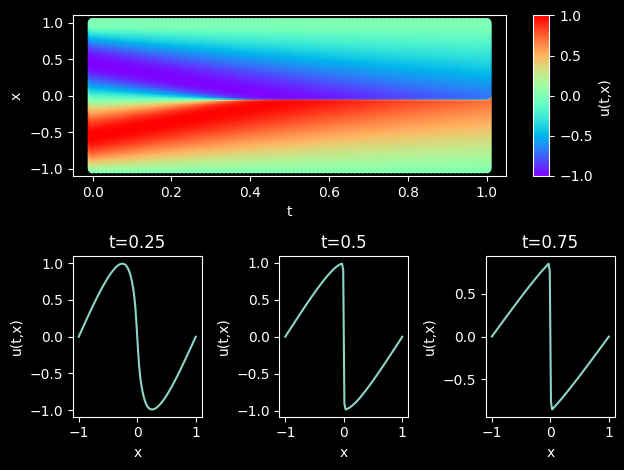

In [11]:
model.trainable_parameters = best_params
visual(case_name, model, config, inputs, label)